In [2]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import sys
import getopt
import errno

sys.path.insert(0,"/home/sunnycui/deepcell-tf")

MODEL_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/models/')
LOG_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/logs/')
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')

In [4]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

import deepcell
from deepcell import losses
from scripts.recurr_gru import image_gen
from deepcell import image_generators
from deepcell import model_zoo

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

Using TensorFlow backend.


# Load Data

In [34]:
filename = 'combined_is_nuclei.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)


print("Loading data from " + filename)
train_dict, test_dict = get_data(DATA_FILE, mode='conv', test_size=0.1, seed=0)

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

Loading data from combined_is_nuclei.npz
 -
X.shape: (199, 160, 160, 1)
y.shape: (199, 160, 160, 1)


### Training params

In [35]:
fgbg_model_name = 'nuclei_model'

n_epoch = 15  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'deepcell'
dilation_radius = 1  # change dilation radius for edge dilation

# Train

In [36]:
fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(train_dict['X'].shape[1:]),
    last_only=False)

In [37]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    train_dict=train_dict,
    test_dict=test_dict,
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (199, 160, 160, 1)
y_train shape: (199, 160, 160, 1)
X_test shape: (23, 160, 160, 1)
y_test shape: (23, 160, 160, 1)
Output Shape: (None, 160, 160, 2)
Number of Classes: 2
Training on 2 GPUs
Epoch 1/15
97/99 [============================>.] - ETA: 0s - loss: 0.5835 - acc: 0.8914
Epoch 00001: val_loss improved from inf to 0.31467, saving model to /home/sunnycui/deepcell-tf/scripts/recurr_gru/models/nuclei_model.h5
99/99 [==============================] - 9s 95ms/step - loss: 0.5767 - acc: 0.8920 - val_loss: 0.3147 - val_acc: 0.9354
Epoch 2/15
97/99 [============================>.] - ETA: 0s - loss: 0.4217 - acc: 0.9273
Epoch 00002: val_loss improved from 0.31467 to 0.30310, saving model to /home/sunnycui/deepcell-tf/scripts/recurr_gru/models/nuclei_model.h5
99/99 [==============================] - 4s 39ms/step - loss: 0.4219 - acc: 0.9273 - val_loss: 0.3031 - val_acc: 0.9264
Epoch 3/15
97/99 [============================>.] - ETA: 0s - loss: 0.3854 - acc: 0.9298
Epoch 000

# Test Images

In [38]:
test_images_fgbg = fgbg_model.predict(test_dict['X'])

print('segmentation mask shape:', test_images_fgbg.shape)

segmentation mask shape: (23, 160, 160, 2)


### Post process

In [44]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

Image number: 11


Text(0.5, 1.0, 'Ground truth')

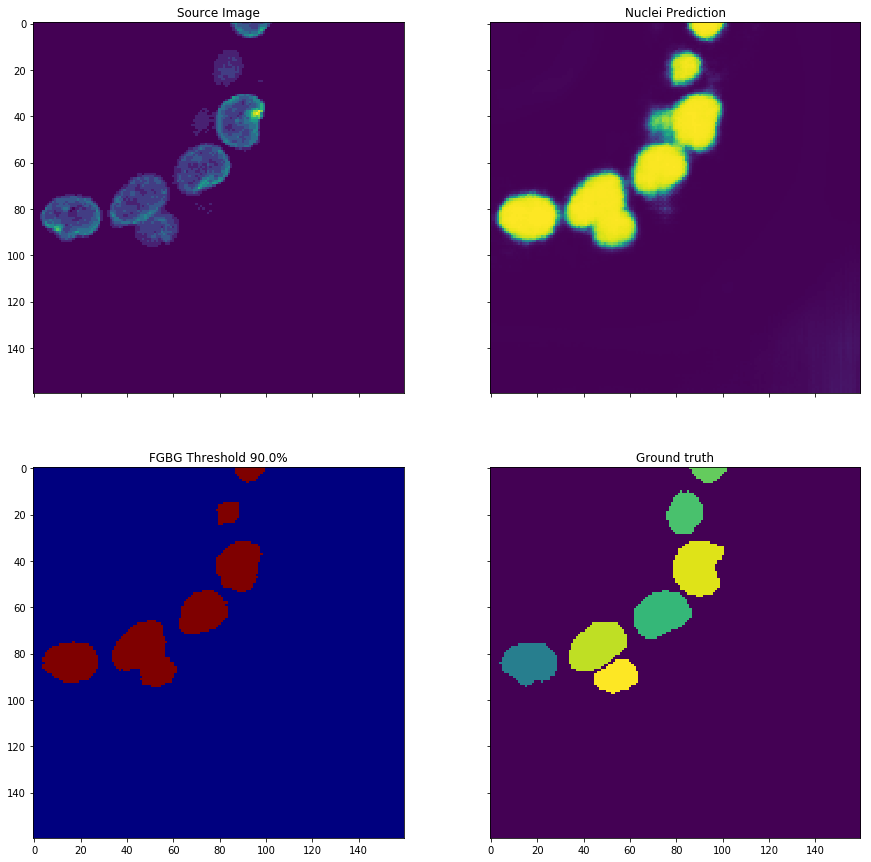

In [46]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=test_dict['X'].shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test_dict['X'][index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Nuclei Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_dict['y'][index,:,:, 0])
ax[3].set_title('Ground truth')